In [1]:
import numpy as np
import pandas as pd

In [1]:
!pip freeze > requriements_rozpoznawanie_obiektow.txt

In [2]:
from IPython.display import FileLink
FileLink('requriements_rozpoznawanie_obiektow.txt')

/kaggle/working/requriements_rozpoznawanie_obiektow.txt

In [2]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44091 sha256=c34a90912c93bcd17c2cd0aeb708a88c8bca01b65685bdd1a3a591cf5bbe493f
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cuml 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
pytorch-lightning 2.0.1.post0 requires PyYAML>=5.4, but you have pyyaml 5.1 which is incompatible.
kubernet

In [3]:
import numpy as np 
import pandas as pd
import torch, detectron2
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib.pyplot as plt

In [4]:
#użycie wcześniej wytrenowanego modelu
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)


[05/21 05:22:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:00, 196MB/s]                             


In [5]:
#wczytanie danych
filelist_all = []
#localhost path
localhost_path = ""
online_path = "/kaggle/input/ads-files-extended"
for dirname, _, filenames in os.walk(online_path):
    for filename in filenames:
        filelist_all.append(os.path.join(dirname, filename))

In [6]:
 def filename_from_path(filepath):
        filename = filepath.split("/")[-1]
        return filename

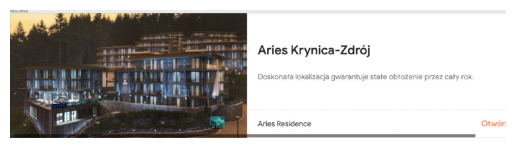

In [19]:
df_full = pd.DataFrame()
for filepath in filelist_all:
#     print(filepath)
    im = cv2.imread(filepath)
    outputs = predictor(im)
    pred_classes = outputs['instances'].pred_classes.cpu().tolist()
    class_names = MetadataCatalog.get("coco_2014_train").thing_classes
    pred_class_names = list(map(lambda x: class_names[x], pred_classes))

    temp = pd.DataFrame(
            {
                'filename': [filename_from_path(filepath)],
                'detected_objects': [pred_class_names],
            })
    df_full = pd.concat([df_full, temp])
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#     plt.imshow(out.get_image()[:, :, ::-1])
#     plt.axis('off')
    

In [8]:
df_full

,filename,detected_objects
0,8deba946-26b2-4769-8b0e-84a2451b57e6.jpg,"[car, bird]"
0,9d1bca23-7dd7-44e9-b000-42ac374d41b9.jpg,"[person, kite]"
0,d13fe224-d966-4082-8602-5fbe1824d62d.jpg,[]
0,4c063f6e-7e89-4800-a7c1-cd595180389d.jpg,"[person, person, person, person, person, perso..."
0,3318700e-de18-4400-9ace-cbe0fb21cd20.jpg,"[cell phone, cup]"
...,...,...
0,ReklamaFacebookOrange.png,"[person, person, person, person, sports ball]"
0,ReklamFacebookaOrlen2.PNG,[]
0,ReklamaFacebookTVP.png,"[person, tie, person, cell phone, chair]"
0,ReklamaFacebookOrlen.PNG,"[tie, person]"


In [9]:
df_full.reset_index(inplace=True)
df_full.drop('index', inplace=True, axis=1)

In [10]:
df_full

,filename,detected_objects
0,8deba946-26b2-4769-8b0e-84a2451b57e6.jpg,"[car, bird]"
1,9d1bca23-7dd7-44e9-b000-42ac374d41b9.jpg,"[person, kite]"
2,d13fe224-d966-4082-8602-5fbe1824d62d.jpg,[]
3,4c063f6e-7e89-4800-a7c1-cd595180389d.jpg,"[person, person, person, person, person, perso..."
4,3318700e-de18-4400-9ace-cbe0fb21cd20.jpg,"[cell phone, cup]"
...,...,...
198,ReklamaFacebookOrange.png,"[person, person, person, person, sports ball]"
199,ReklamFacebookaOrlen2.PNG,[]
200,ReklamaFacebookTVP.png,"[person, tie, person, cell phone, chair]"
201,ReklamaFacebookOrlen.PNG,"[tie, person]"
